In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf

In [ ]:
mnist_data = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist_data.load_data()

# Preprocess the data
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 10 # There are 10 classes in MNIST
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Take a look the training data
print('Training.images shape: ', X_train.shape)
print('Shape of an image: ', X_train[0].shape)
print('Example label: ', y_train[0])
print('Example label(one hot): ', y_train_one_hot[0])

Training.images shape:  (60000, 784)
Shape of an image:  (784,)
Example label:  5
Example label(one hot):  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


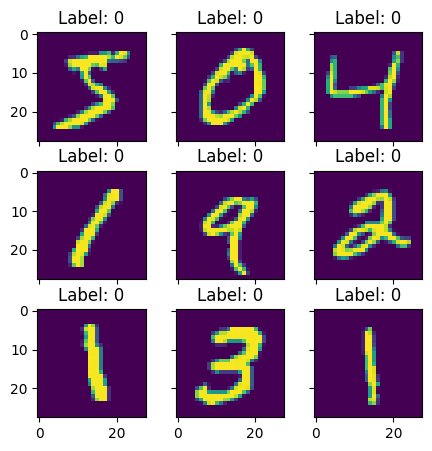

In [ ]:
# Review a few images
image_list = X_train[0:9]
image_list_labels = y_train[0:9]

# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#imagegrid
fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i in range(len(image_list)):
    image = image_list[i].reshape(28,28)
    grid[i].imshow(image)
    grid[i].set_title('Label: {0}'.format(image_list_labels[i].argmax()))

plt.show()

In [ ]:
# Define the model as a class inheriting from tf.keras.Model
class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define layers of the model
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=1024, activation='relu')
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.fc2 = tf.keras.layers.Dense(units=10)

    def call(self, x, training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])  # Reshape input to 28x28x1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        if training:
            x = self.dropout(x, training=training)
        return self.fc2(x)



In [ ]:
# Instantiate the model
model = CNNModel()

# Define a loss function
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an optimizer
optimizer = tf.keras.optimizers.Adam()

# Define a metric for accuracy
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# Define a training step as a tf.function to convert it to a graph for performance
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_function(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy(labels, predictions)
    return loss

# batch size
batch_size = 100

# Create a tf.data.Dataset object for the training data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot)).shuffle(60000).batch(batch_size)

In [ ]:
# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    for images, labels in train_dataset:
        loss = train_step(images, labels)
    print(f"Epoch {epoch}, Loss: {loss.numpy()}, Accuracy: {train_accuracy.result().numpy()}")
    train_accuracy.reset_states()

Epoch 0, Loss: 0.034142039716243744, Accuracy: 0.9896500110626221
Epoch 1, Loss: 0.018635161221027374, Accuracy: 0.9926000237464905
Epoch 2, Loss: 0.0017152753425762057, Accuracy: 0.9943166375160217
Epoch 3, Loss: 0.06819222122430801, Accuracy: 0.995033323764801


In [ ]:
# Evaluation step for test data
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_function(labels, predictions)
    test_accuracy(labels, predictions)
    return t_loss

# Define a metric for test accuracy
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# Create a tf.data.Dataset object for the test data
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot)).batch(batch_size)

# Evaluate the model on the test dataset
test_loss = 0
for test_images, test_labels in test_dataset:
    test_loss += test_step(test_images, test_labels)

# Print the test accuracy
print(f"Test Loss: {test_loss / len(test_dataset)}, Test Accuracy: {test_accuracy.result().numpy()}")

Test Loss: 0.02656865119934082, Test Accuracy: 0.9909999966621399


In [ ]:
def plot_predictions(model, image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately.
    Return probability list if output_probs == True.
    '''
    # reshape image_list as 4D tensor with shape (num_images, 28, 28, 1)
    image_list_reshaped = image_list.reshape(-1, 28, 28, 1)

    # Get model predictions (logits)
    logits = model(image_list_reshaped, training=False)

    # Convert logits to probabilities
    prob = tf.nn.softmax(logits).numpy()

    pred_list = np.argmax(prob, axis=1)
    pct_list = np.max(prob, axis=1) * 100

    # Setup image grid
    cols = 3
    rows = int(np.ceil(image_list.shape[0] / cols))
    fig = plt.figure(1, (9., 9.))
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.5)

    # Get probs, images and populate grid
    for i in range(len(prob)):
        image = image_list[i].reshape(28, 28)
        grid[i].imshow(image)
        #grid[i].imshow(image, cmap='gray')

        title = 'Label: {0} \nCertainty: {1:.1f}%'.format(pred_list[i], pct_list[i])

        # Only use when plotting original, partial derivatives, and adversarial images
        if adversarial and i % 3 == 1:
            title = "Adversarial \nPartial Derivatives"

        grid[i].set_title(title, fontdict={'verticalalignment': 'center'})
        grid[i].axis('off')

    plt.show()

    return prob if output_probs else None

In [ ]:
def get_images_of_label(X, y, label, no_of_images):

    # Find the indices where the labels match the specific label
    indices_of_label = np.where(y == label)[0]

    #selected_indices = indices_of_label[:no_of_images]
    selected_indices = np.random.choice(indices_of_label, no_of_images, replace=False)

    return X[selected_indices]


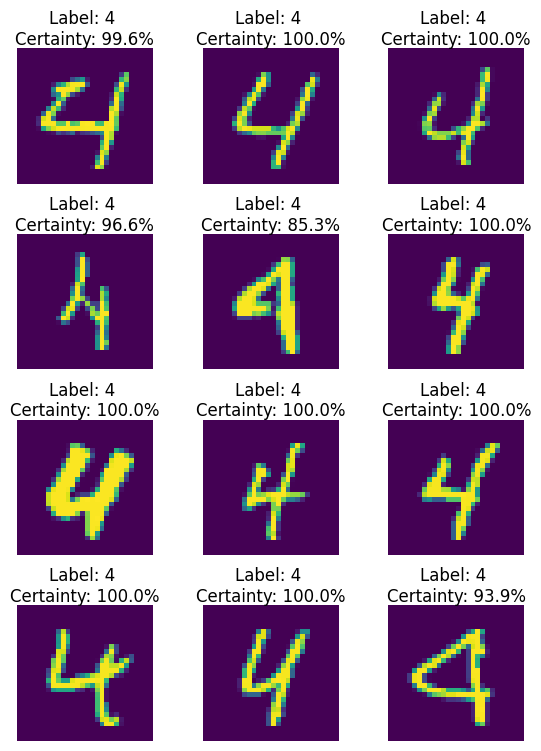

In [ ]:
label_of_interest = 4
number_of_images = 12

selected_images = get_images_of_label(X_train, y_train, label_of_interest, number_of_images)

plot_predictions(model, selected_images)

In [ ]:
def create_plot_adversarial_images(model, x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    original_image = x_image
    probs_per_step = []

    # Convert to a tensor
    x_image = tf.convert_to_tensor(x_image, dtype=tf.float32)

    # Perform the adversarial image generation steps
    for _ in range(n_steps):
        with tf.GradientTape() as tape:
            tape.watch(x_image)
            prediction = model(x_image)
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=prediction)

        # Calculate derivatives of loss w.r.t x_image
        deriv = tape.gradient(loss, x_image)

        # Create the adversarial image by adjusting the original image by the derivatives
        x_image_adv = tf.stop_gradient(x_image - tf.sign(deriv) * (lr / n_steps))
        x_image_adv = tf.clip_by_value(x_image_adv, 0, 1)  # Ensure pixel values are valid

        # Evaluate the model with the adversarial image
        x_adv_eval = x_image_adv.numpy()
        img_adv_list = np.vstack([original_image, deriv[0].numpy(), x_adv_eval])

        # Print/plot images and return probabilities
        probs = plot_predictions(model, img_adv_list, output_probs=output_probs, adversarial=True)
        if output_probs:
            probs_per_step.append(probs)

    return probs_per_step




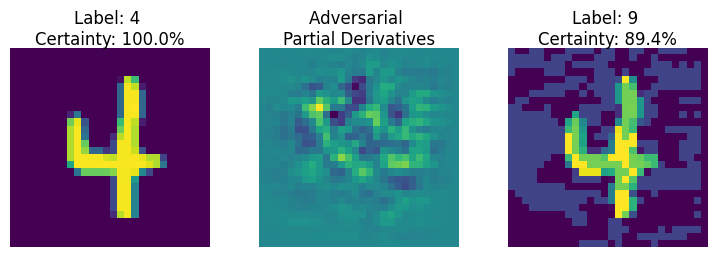

[]

In [ ]:
label_of_interest = 4
number_of_images = 1

selected_images = get_images_of_label(X_test, y_test, label_of_interest, number_of_images)

image_norm = np.reshape(selected_images, (1, 784))
label_adv = [0,0,0,0,0,0,0,0,0,1] # one hot encoded, adversarial label 9

create_plot_adversarial_images(model, image_norm, label_adv, lr=0.2, n_steps=1)